# Title

# Abstract

# Table of contents <a name="TOC"></a>
1. [Introduction](#intro)
2. [Data aquisition](#data-aquisition)
3. [Data exploration](#data-exploration)

# Introduction <a name="intro"></a>

[Go back to the top](#TOC)

# Data acquisition <a name="data-aquisition"></a>

[Go back to the top](#TOC)

The data we analyse are given by the NTDS course. They can be downloaded from [here](https://linqs-data.soe.ucsc.edu/public/lbc/TerrorAttack.tgz).

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.linear_model import Ridge, RidgeCV
from sklearn.cross_validation import KFold
from sklearn.model_selection import cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn import preprocessing, decomposition

import networkx as nx

from scipy import sparse, stats, spatial
import scipy.sparse.linalg

C:\Users\Loic\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
PATH = "TerrorAttack/"
SEED = 0

In [3]:
# Load data
edges_org = pd.read_csv(PATH +'terrorist_attack_loc_org.edges', sep=' ', header=None)
edges = pd.read_csv(PATH +'terrorist_attack_loc.edges', sep=' ', header=None)
labels = pd.read_csv(PATH +'terrorist_attack.labels', sep=' ', header=None)
nodes = pd.read_csv(PATH +'terrorist_attack.nodes', sep='\t', header=None)

In [4]:
n_nodes = nodes.shape[0]

# Data exploration and cleaning <a name="data-exploration"></a>

[Go back to the top](#TOC)

In [5]:
edges.head()

,0,1
0,http://counterterror.mindswap.org/2005/ict_eve...,http://counterterror.mindswap.org/2005/ict_eve...
1,http://counterterror.mindswap.org/2005/ict_eve...,http://counterterror.mindswap.org/2005/ict_eve...
2,http://counterterror.mindswap.org/2005/ict_eve...,http://counterterror.mindswap.org/2005/ict_eve...
3,http://counterterror.mindswap.org/2005/ict_eve...,http://counterterror.mindswap.org/2005/ict_eve...
4,http://counterterror.mindswap.org/2005/ict_eve...,http://counterterror.mindswap.org/2005/ict_eve...


In [6]:
edges[0][42]

'http://counterterror.mindswap.org/2005/ict_events.owl#Jihad_Group_19961117'

The edges are given by an internet link. However, there are information given inside the link: the name of the organization after `#` in the link and the date of the attack and the end of the link.  
  
We will extract these information and construct a new data frame.

In [7]:
# extract information of date and organization from the link
nodes_info = nodes[0].apply(lambda x : (x.split("#"))[1])
dates= nodes_info.apply(lambda x : x[-8:])
dates = pd.to_datetime(dates, format='%Y%m%d', errors='coerce')
organizations = nodes_info.apply(lambda x : x[:-9])

attacks_dict = {"organization": organizations, "date": dates}
attacks = pd.DataFrame(attacks_dict)

attacks.head()

,organization,date
0,United_Popular_Action_Movement,1993-05-13
1,Unknown,1996-11-12
2,Unknown,1998-04-28
3,Kurdistan_Worker_s_Party,1997-03-25
4,Unknown,1999-03-14


We observe that there are some unknown organizations. We want to know the number of the unknown values.

In [8]:
attacks.organization.value_counts().head()

Unknown                      519
Hamas                         99
Fatah_Tanzim                  52
Palestinian_Islamic_Jihad     50
                              48
Name: organization, dtype: int64

That is pretty much. We may predict the organization who is responsible of an attack for those unknown author. First, we check the proportion of attacks that are created by known organizations which create at least 10 attacks. In fact, if an organization only have few rows in the `nodes` dataset, it will be difficult to extract information from the limited rows.

In [9]:
nb_atk_threshold = 10

In [10]:
attacks.organization.replace('', 'Unknown', inplace=True)

In [11]:
attack_per_org = pd.DataFrame(attacks.organization.value_counts()[1:])
attack_per_org.columns=['count']
num_attacks = attack_per_org.sum()
prop_freq_org = (attack_per_org[attack_per_org['count']>=nb_atk_threshold].sum() / num_attacks )['count']

print("There are {:.2%} of known attacks are created by frequent organizations.".format(prop_freq_org))

There are 80.30% of known attacks are created by frequent organizations.


Which seems good for us to predict.

In [12]:
# concatenate features into the dataframe of attacks
attacks = pd.concat([attacks, nodes.iloc[:, 1:]], axis=1)

# get only the type of attack from last column
attacks.iloc[:, -1] = nodes.iloc[:, -1].apply(lambda x: x.split('#')[1])

attacks.head()

,organization,date,1,2,3,4,5,6,7,8,...,98,99,100,101,102,103,104,105,106,107
0,United_Popular_Action_Movement,1993-05-13,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Arson
1,Unknown,1996-11-12,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Arson
2,Unknown,1998-04-28,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Arson
3,Kurdistan_Worker_s_Party,1997-03-25,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Arson
4,Unknown,1999-03-14,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Arson


In [13]:
ls = sorted(attacks.date[attacks.date.notna()])

We will now also have a look on the number of attacks w.r.t time. 

In [14]:
attack_year = [t.year for t in ls]

print("Our data contains attacks start from year {} till {}"
      .format(min(set(attack_year)), max(set(attack_year))))

Our data contains attacks start from year 1969 till 2002


C:\Users\Loic\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


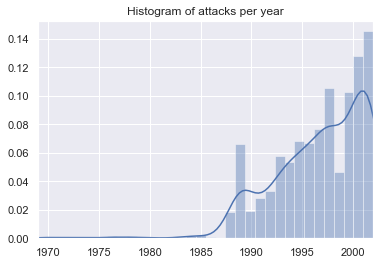

In [15]:
sns.distplot(attack_year, bins=34)
plt.title('Histogram of attacks per year')
plt.xlim([1969,2002]);

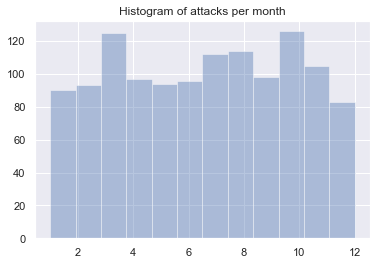

In [16]:
attack_month = [t.month for t in ls]

sns.distplot(attack_month, bins=12, kde=False)
plt.title('Histogram of attacks per month');

## Building a feature graph

In [17]:
features = pd.get_dummies(nodes.iloc[:, 1:])

distances = pdist(features)
kernel_width = distances.mean()
weights = np.exp(-distances**2 / kernel_width**2)
features_adjacency = squareform(weights)

In [20]:
# put the diagonal values to 0
features_adjacency[(range(n_nodes), range(n_nodes))] = 0

In [21]:
features_adjacency

array([[0.        , 0.43382023, 0.4604858 , ..., 0.38503208, 0.4086988 ,
        0.30329912],
       [0.43382023, 0.        , 0.51883484, ..., 0.38503208, 0.36273585,
        0.34173073],
       [0.4604858 , 0.51883484, 0.        , ..., 0.51883484, 0.38503208,
        0.32194197],
       ...,
       [0.38503208, 0.38503208, 0.51883484, ..., 0.        , 0.4086988 ,
        0.38503208],
       [0.4086988 , 0.36273585, 0.38503208, ..., 0.4086988 , 0.        ,
        0.36273585],
       [0.30329912, 0.34173073, 0.32194197, ..., 0.38503208, 0.36273585,
        0.        ]])

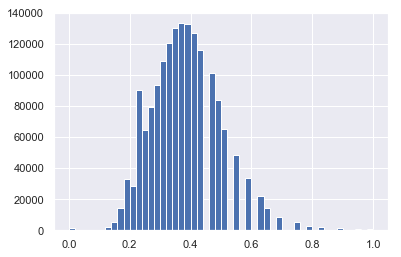

In [22]:
plt.hist(features_adjacency.ravel(), bins=50);

In [23]:
# sparsify the matrix 
spase_f_adjacency = np.copy(features_adjacency)


spase_f_adjacency[spase_f_adjacency < 0.7] = 0 

degrees = spase_f_adjacency.sum(axis=0)
adjacency_cleaned = sparse.coo_matrix(spase_f_adjacency[degrees != 0][:,degrees != 0])
n_nodes =  adjacency_cleaned.shape[0]
adjacency_cleaned.shape

(848, 848)

In [24]:
n_nodes = len(nodes)

In [25]:
coloc_adjacency = np.zeros((n_nodes, n_nodes), dtype=int)
for idx, row in edges.iterrows():
    n1, n2 = row # retrieve the nodes from the edge
    idx_n1 = nodes[nodes[0] == n1].index[0]
    idx_n2 = nodes[nodes[0] == n2].index[0]
    
    # increment by one in (n1, n2) and (n2, n1) entries
    coloc_adjacency[idx_n1, idx_n2] += 1
    coloc_adjacency[idx_n2, idx_n1] += 1

coloc_org_adjacency = np.zeros((n_nodes, n_nodes), dtype=int)
for idx, row in edges_org.iterrows():
    n1, n2 = row # retrieve the nodes from the edge
    idx_n1 = nodes[nodes[0] == n1].index[0]
    idx_n2 = nodes[nodes[0] == n2].index[0]
    
    # increment by one in (n1, n2) and (n2, n1) entries
    coloc_org_adjacency[idx_n1, idx_n2] += 1
    coloc_org_adjacency[idx_n2, idx_n1] += 1

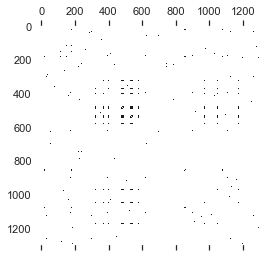

In [26]:
plt.spy(coloc_adjacency)

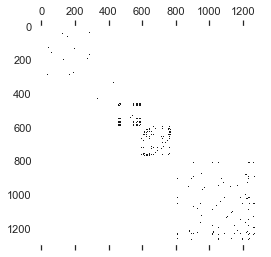

In [27]:
plt.spy(spase_f_adjacency)

In [28]:
g2 = nx.from_numpy_array(adjacency_cleaned.toarray())

Save the graph to use it in gephi

In [ ]:
nx.write_gexf(g2,'feature_graph.gexf')

# Finding organisations reponsible of an attack

In [44]:
# only select organizations 
famous_orgs = attack_per_org[attack_per_org['count'] >= 10]

# create a mapping between the organizations and labels
idx_to_org = pd.DataFrame(famous_orgs.index, columns=['organization'])
org_to_idx = idx_to_org.reset_index().set_index('organization')

idx_to_org.head()

X = features[attacks.organization.apply(lambda x: x in org_to_idx.index)]
y = attacks[attacks.organization.apply(lambda x: x in org_to_idx.index)].organization.apply(lambda x: org_to_idx.loc[x])

## Using PCA and K-Means

Try first if it can recognize 3 different groups

In [45]:
# only select organizations 
famous_orgs = attack_per_org[attack_per_org['count'] > 46]  

# create a mapping between the organizations and labels
idx_to_org = pd.DataFrame(famous_orgs.index, columns=['organization'])
org_to_idx = idx_to_org.reset_index().set_index('organization')

idx_to_org.head()

X = features[attacks.organization.apply(lambda x: x in org_to_idx.index)]
y = attacks[attacks.organization.apply(lambda x: x in org_to_idx.index)].organization.apply(lambda x: org_to_idx.loc[x])

Text(0.5, 1.0, 'PCA embedding')

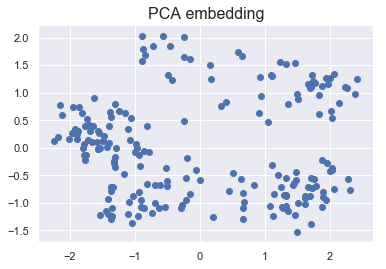

In [46]:
features_pca = decomposition.PCA(n_components=2).fit_transform(X)
g = plt.scatter(features_pca[:, 0], features_pca[:, 1]);
plt.title('PCA embedding', size=16)

In [161]:
H = features_pca
clusters3 = KMeans(n_clusters=k, random_state=0).fit_predict(H)

Text(0.5, 1.0, 'K-means cluster assignment PCA')

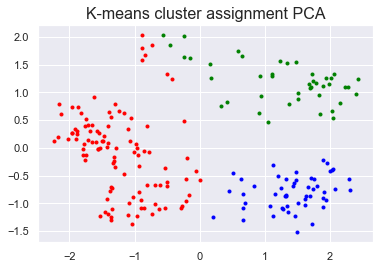

In [171]:
colors = ['Red', 'Blue', 'Green']

for i in range(3):
    cluster = features_pca[np.where(clusters3 == i)[0], :].real
    plt.plot(cluster[:,0],cluster[:,1], '.', color=colors[i])
    
plt.title('K-means cluster assignment PCA', size=16)

In [168]:
labels = y['index'].values
translate = {0:1, 1:0, 2:2}
labels = np.vectorize(translate.get)(labels)

In [169]:
((labels == clusters3).sum() / labels.shape[0])*100

71.14427860696517

We see 3 some clusters, possibly 3. Now what happens if we put the labels ?

Text(0.5, 1.0, 'PCA embedding with ground truth labels')

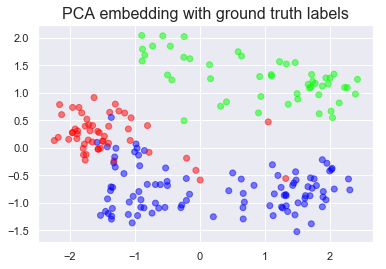

In [167]:
g = plt.scatter(features_pca[:, 0], features_pca[:, 1], c=y['index'], cmap='brg', alpha=0.5);
plt.title('PCA embedding with ground truth labels', size=16)

## Using Spectral Embedding and K-Means

Again, test if we can recognize 3 groups 

In [48]:
# only select organizations 
famous_orgs = attack_per_org[attack_per_org['count'] > 46]  

# create a mapping between the organizations and labels
idx_to_org = pd.DataFrame(famous_orgs.index, columns=['organization'])
org_to_idx = idx_to_org.reset_index().set_index('organization')

idx_to_org.head()

X = features[attacks.organization.apply(lambda x: x in org_to_idx.index)]
y = attacks[attacks.organization.apply(lambda x: x in org_to_idx.index)].organization.apply(lambda x: org_to_idx.loc[x])

In [49]:
distances = pdist(X)
kernel_width = distances.mean()
weights = np.exp(-distances**2 / kernel_width**2)
features_adjacency = squareform(weights)

spase_f_adjacency = np.copy(features_adjacency)

spase_f_adjacency[spase_f_adjacency < 0.35] = 0 

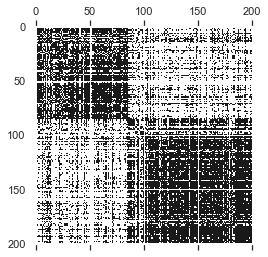

In [50]:
degrees = spase_f_adjacency.sum(0)

adjacency_cleaned = sparse.coo_matrix(spase_f_adjacency[degrees != 0][:,degrees != 0])
n_nodes =  adjacency_cleaned.shape[0]
adjacency_cleaned.shape
degrees = degrees[degrees != 0]



# Combinatorial Laplacian.
laplacian = np.diag(degrees) - adjacency_cleaned
# Normalized Laplacian.
deg_inv = np.diag(1 / np.sqrt(degrees))
laplacian = deg_inv @ laplacian @ deg_inv


plt.spy(laplacian);


laplacian = sparse.csr_matrix(laplacian)

graph embedding:

In [96]:
eigenvalues, eigenvectors = sparse.linalg.eigsh(laplacian, k=3, which='SM')

Text(0.5, 1.0, 'Spectral graph embedding')

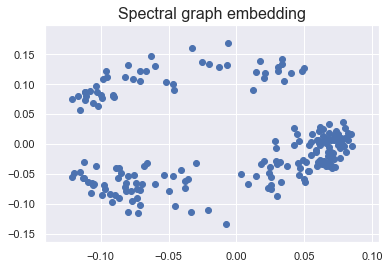

In [97]:
sortID = np.argsort(eigenvalues)
eigenvalues = eigenvalues[sortID]
eigenvectors = eigenvectors[:,sortID]
proj  = eigenvectors[:,1:3]
plt.scatter(proj[:,0],proj[:,1])
plt.title('Spectral graph embedding', size=16)

K-means:

In [98]:
#Computation of the eigenvalues and eigenvectors for our graph
[eigenvalues_lc, eigenvectors_lc] = sparse.linalg.eigsh(laplacian, k = degrees.shape[0]-1, which = 'LM')
#This function will not return the first 0 because it is assuming it is always there. 
#So when we now look at eigenvalues we had not to forget that there is one more 0.
sortID = np.argsort(eigenvalues_lc)
eigenvalues_lc = eigenvalues_lc[sortID]
eigenvectors_lc = eigenvectors_lc[:,sortID]

In [175]:
from sklearn.cluster import KMeans

# For k=3 and d=3
k = 3; d = 3
H = eigenvectors_lc[:,:d]; 
clusters3 = KMeans(n_clusters=k, random_state=0).fit_predict(H)

Cluster that k-means gives us:

Text(0.5, 1.0, 'K-means cluster assignment')

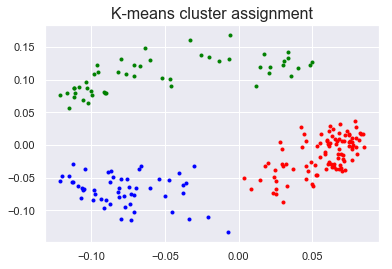

In [176]:
colors = ['Red', 'Green', 'Blue']

for i in range(3):
    cluster = proj[np.where(clusters3 == i)[0], :].real
    plt.plot(cluster[:,0],cluster[:,1], '.', color=colors[i])
    
plt.title('K-means cluster assignment', size=16)

In [177]:
labels = y['index'].values
labels = (labels + 2) % 3

In [178]:
((labels == clusters3).sum() / labels.shape[0])*100

75.12437810945273

What if we use our labels instead ?

Text(0.5, 1.0, 'Ground truth assigment')

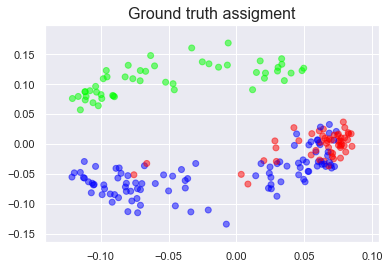

In [104]:
plt.scatter(proj[:,0],proj[:,1], c=y['index'], cmap='brg', alpha=0.5)
plt.title('Ground truth assigment', size=16)

Close

## Using Linear Support Vector Classification.

#### Check similarity within organization

To see if it is relevant to try to predict the organizations based on the features, we check if the feature distance between attacks of the same organization are smaller than across organizations.

In [26]:
diffs = []

for i in range(n_nodes):
    org = attacks['organization'][i]
    sim = features_adjacency[i]
    if org != 'Unknown' and attack_per_org.loc[org]['count'] >= 10:
        org_indices = attacks[attacks.organization == org].index
        diffs += [sim[org_indices].mean() - sim.mean()]

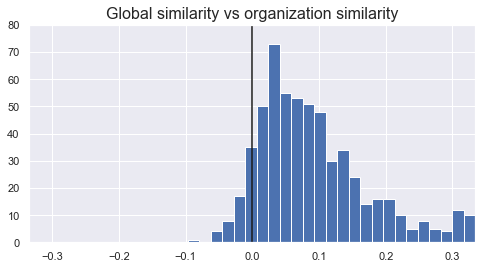

In [29]:
plt.figure(figsize=(8,4))
plt.hist(diffs, bins=25)
plt.xlim(-max(diffs), max(diffs))
plt.ylim((0, 80))
plt.vlines(0, 0, 80)
plt.title('Global similarity vs organization similarity', size=16)
plt.savefig('similarity_difference.png');

In [44]:
# only select organizations 
famous_orgs = attack_per_org[attack_per_org['count'] >= 10]

#### Cross-validation

In [45]:
# create a mapping between the organizations and labels
idx_to_org = pd.DataFrame(famous_orgs.index, columns=['organization'])
org_to_idx = idx_to_org.reset_index().set_index('organization')

idx_to_org.head()

,organization
0,Hamas
1,Fatah_Tanzim
2,Palestinian_Islamic_Jihad
3,Basque_Homeland_and_Freedom
4,Martyrs_of_al-Aqsa


In [33]:
X = features[attacks.organization.apply(lambda x: x in org_to_idx.index)]
y = attacks[attacks.organization.apply(lambda x: x in org_to_idx.index)].organization.apply(lambda x: org_to_idx.loc[x])

In [34]:
correct = Counter()
total = Counter()

for train_idx, test_idx in KFold(X.shape[0], 4, shuffle=True, random_state=SEED):
    # split the data
    X_train = X.iloc[train_idx]
    y_train = y.iloc[train_idx]
    X_test = X.iloc[test_idx]
    y_test = y.iloc[test_idx]
    
    # fit the model
    model = OneVsRestClassifier(LinearSVC(random_state=SEED))
    model.fit(X_train, y_train)
    
    # predict
    y_pred = model.predict(X_test)
    
    y_pred_orgs = idx_to_org.loc[y_pred]
    y_test_orgs = idx_to_org.loc[y_test['index']]
    
    for i in range(len(y_pred)):
        y_p = y_pred_orgs.iloc[i].organization
        y_t = y_test_orgs.iloc[i].organization

        total[y_t] += 1
        if y_p == y_t:
            correct[y_t] += 1

In [35]:
prediction_comparision = pd.DataFrame([correct, total]).T.fillna(0)
prediction_comparision.columns = ['correct', 'total']

In [36]:
correctly_predicted = prediction_comparision.correct.sum()
print('With %d correct predictions from a total of %d samples, we obtain a success rate of %.3f%%.'
      % (correctly_predicted, y.shape[0], 100 * correctly_predicted / y.shape[0]))

With 532 correct predictions from a total of 583 samples, we obtain a success rate of 91.252%.


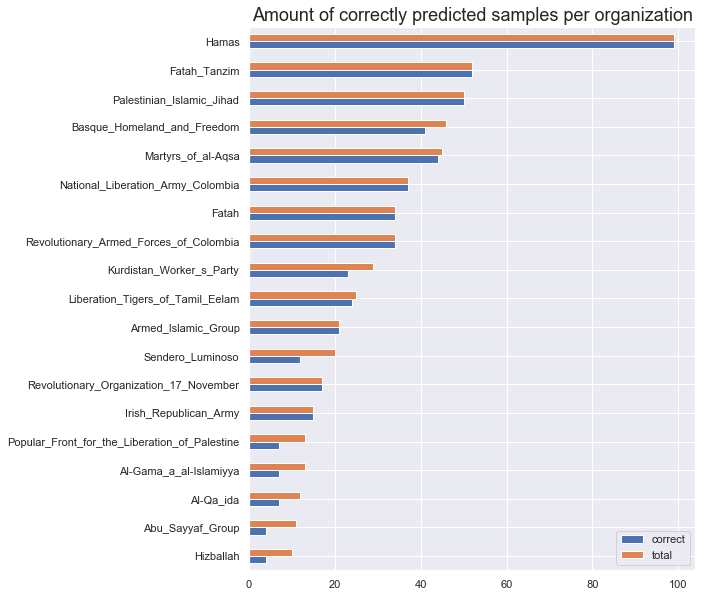

In [37]:
prediction_comparision.sort_values('total').plot.barh(figsize=(8, 10))
plt.title('Amount of correctly predicted samples per organization', size=18);

For most of the top 19 organizations, the predictions we obtain are very accurate! We observe however that our model has more trouble predicting organizations with few attacks because of the consequently small amount of training data for the organization.

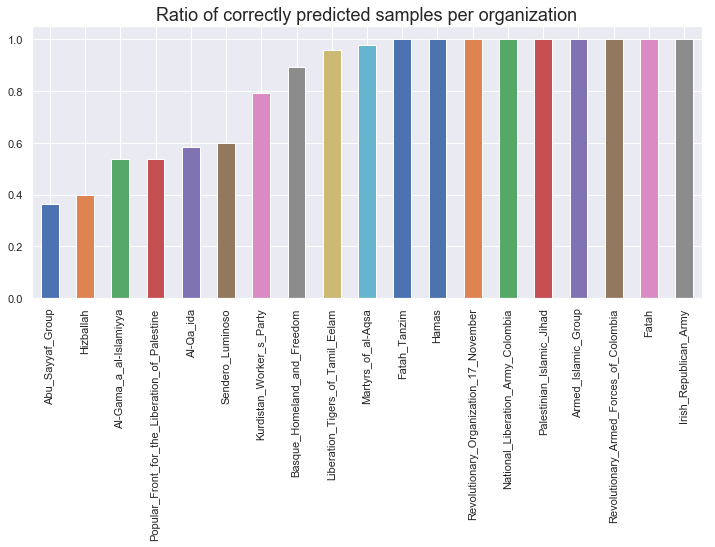

In [38]:
(prediction_comparision.correct / prediction_comparision.total).sort_values().plot.bar(figsize=(12,5))
plt.title('Ratio of correctly predicted samples per organization', size= 18);

#### Predict the unknown organizations

In [42]:
X_train = features[attacks.organization.apply(lambda x: x in org_to_idx.index)]
y_train = attacks[attacks.organization.apply(lambda x: x in org_to_idx.index)].organization.apply(lambda x: org_to_idx.loc[x])
X_unknown = features[attacks.organization.apply(lambda x: x in 'Unknown')]

model = OneVsRestClassifier(LinearSVC(random_state=SEED))
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_unknown)
y_pred_orgs = idx_to_org.loc[y_pred]

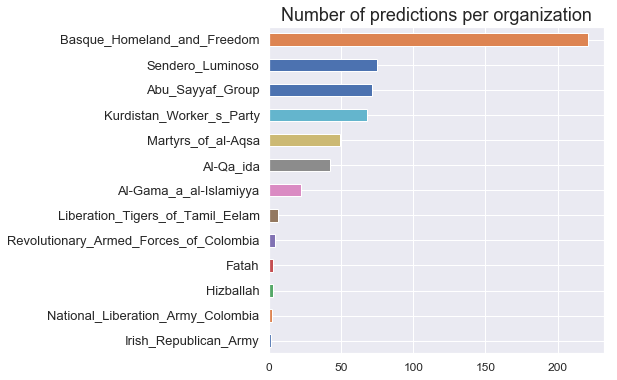

In [43]:
y_pred_orgs.organization.value_counts().iloc[::-1].plot.barh(figsize=(6, 6))
plt.title('Number of predictions per organization', size=18)
plt.yticks(size=13)
plt.xticks(size=12)
plt.savefig('unknown_predictions.png');